# Phylogenetic trees and Data remapping

    run --mem-per-cpu=35g --time=20:00:00 jupyter nbconvert --execute --to notebook --inplace nb_01_trees_and_remapping.ipynb 

jupyter nbconvert --execute --to notebook --inplace <notebook>

from scipy import signal
import numpy as np
import pandas as pd
import bisect
import importlib
import warnings
from pathlib import Path
import gc
import os

import ete3
np.random.seed(7)

In [26]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("white")
sns.set_context("notebook")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

Monospace font for numbers in tables:

In [27]:
%%html
<style> table { font-variant-numeric: tabular-nums; } </style>

## Data dir

In [28]:
data_path = Path('/project/Birds/faststorage/data')
results_path = Path('/project/Birds/faststorage/people/kmt/results')
figures_path = Path('/project/Birds/faststorage/people/kmt/figures')

## Branch lenghts

UPGMA code:

In [29]:
def find_lowest_cell(table):
    x = 1
    y = 0
    min_val = table[x][y]
    for i in range(len(table)):
        for j in range(len(table[i])):
            if table[i][j] < min_val:
                min_val = table[i][j]
                x = i
                y = j
    return [x, y]

def link(x, y, wx, wy):
    return (x * wx + y * wy) / (wx + wy)

def update_table(table, a, b, weight_a, weight_b):
    for i in range(0, b):
        table[b][i] = link(table[b][i], table[a][i], weight_b, weight_a)
    for j in range(b+1, a):
        table[j][b] = link(table[j][b], table[a][j], weight_b, weight_a)
    for i in range(a+1, len(table)):
        table[i][b] = link(table[i][b], table[i][a], weight_b, weight_a)
    for i in range(a+1, len(table)):
        del table[i][a]
    del table[a] 

def update_labels(labels, i, j, di, dj):
    labels[j] = "({}:{},{}:{})".format(labels[j], dj, labels[i], di)
    del labels[i]

def upgma(mat, names):

    table = mat[:]
    labels = names[:]
    node_heights = [0 for _ in labels]

    while len(labels) > 1:
        i, j = find_lowest_cell(table)
        
        dist = table[i][j]

        wi = max(1, labels[i].count(':'))
        wj = max(1, labels[j].count(':'))

        new_node_height = dist / 2
        di = new_node_height - node_heights[i]
        dj = new_node_height - node_heights[j]
        
        update_table(table, i, j, wi, wj)
        update_labels(labels, i, j, di, dj)
        node_heights[j] = new_node_height
        del node_heights[i]
        
    return labels[0] + ';'

Tree plotting code:

In [30]:
def plot_tree(t, ax, leaf_colors=None, show_inner_nodes=False, fontsize=10, 
              text_offset=None, margins=(0.5, 1, 0.5, 1), align_labels=False): # top, right, bottom, left

    y_offset = len(t.get_leaves())
    for node in t.traverse("preorder"):
        node.x_offset = node.dist + sum(x.dist for x in node.get_ancestors())
        if node.is_leaf():
            y_offset -= 1
            node.y_offset = y_offset

    for node in t.traverse("postorder"):
        if not node.is_leaf():
            node.y_offset = sum(x.y_offset for x in node.children) / len(node.children)

    horizontal_lines = list()
    vertical_lines = list()
    node_coords = list()
    leaf_coords = list()
    max_x_offset = 0
    for node in t.traverse("postorder"):
        max_x_offset = max(max_x_offset, node.x_offset)
        node_coords.append((node.x_offset, node.y_offset))
        if node.is_leaf():
            leaf_coords.append([node.name, node.x_offset, node.y_offset])
        if not node.is_root():
            y = node.y_offset
            horizontal_lines.append(([node.up.x_offset, node.x_offset], [y, y]))
        if not node.is_leaf():
            c = sorted(node.children, key=lambda x: x.y_offset)
            bottom, top = c[0], c[-1]
            x = node.x_offset
            vertical_lines.append(([x, x],[bottom.y_offset, top.y_offset]))

    
    # shift the tree to put leaves at zero
    for i in range(len(horizontal_lines)):
        horizontal_lines[i][0][0] -= max_x_offset
        horizontal_lines[i][0][1] -= max_x_offset
    for i in range(len(vertical_lines)):
        vertical_lines[i][0][0] -= max_x_offset
        vertical_lines[i][0][1] -= max_x_offset
    for i in range(len(leaf_coords)):
        leaf_coords[i][1] -= max_x_offset
            
    # draw the tree:
    for x in horizontal_lines:
        ax.plot(*x, c='black', linewidth=0.8)
    for x in vertical_lines:
        ax.plot(*x, c='black', linewidth=0.8)

#     for tup in node_coords:
#         ax.plot(*tup, c='black', marker="o")

    if text_offset is None:
        text_offset = max_x_offset / 20
        
    for name, x, y in leaf_coords:
        
        name = name.split('_', 1)[1].replace('_', ' ').capitalize()

        
        if align_labels:
            ax.text(0+text_offset, y, name, fontsize=fontsize, backgroundcolor='white',
                    verticalalignment='center', horizontalalignment='left')
            if leaf_colors is None:
                color = 'black'
            else:
                color = leaf_colors[name]
            ax.plot(x, y, c=color, marker="o", ms=3)

            ax.add_line(Line2D((x, margins[1]), (y, y), linewidth=0.8, color='grey', linestyle='dashed', zorder=0))
        else:
            ax.text(x+text_offset, y, name, fontsize=fontsize, backgroundcolor='white',
                    verticalalignment='center', horizontalalignment='left')
            if leaf_colors is None:
                color = 'black'
            else:
                color = leaf_colors[name]
            ax.plot(x, y, c=color, marker="o", ms=3)


#     ax.set_xlim(-margins[3], max_x_offset + margins[1])
    ax.set_xlim(-margins[3]-max_x_offset, margins[1])
    ax.set_ylim(-margins[2], len(leaf_coords)-1+margins[0])


    #ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax.spines['top'].set_visible(False) 
    ax.spines['left'].set_visible(False) 
    ax.spines['right'].set_visible(False)
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    
    return leaf_coords


def make_comb_tree(t):
    for node in t.traverse():
        if not node.is_leaf():
            node.children = sorted(node.children, key=lambda c: len(c.get_leaves()), reverse=False)
    

Read in tree make ultrametric version:

In [31]:
with open(data_path / 'tree_ancestors_species2014_english.txt') as f:
    s = f.read().strip()
tree = ete3.Tree(s, format=1)

In [32]:
tree.prune([x for x in tree.get_leaves() if x.name != 'HALAL_white-tailed_eagle'], preserve_branch_length=True)
#print(str(tree))

Make a UPGMA tree:

In [33]:
name_list = tree.get_leaf_names()
lowtri = list()
for i in range(len(name_list)):
    lowtri.append([])
    for j in range(i):
        lowtri[i].append((tree&name_list[i]).get_distance(name_list[j]))
        
upgma_tree = ete3.Tree(upgma(lowtri, name_list), format=1)

TENT tree made ultrametric:

In [34]:
ultrametric_tree = tree.copy()
ultrametric_tree.convert_to_ultrametric()

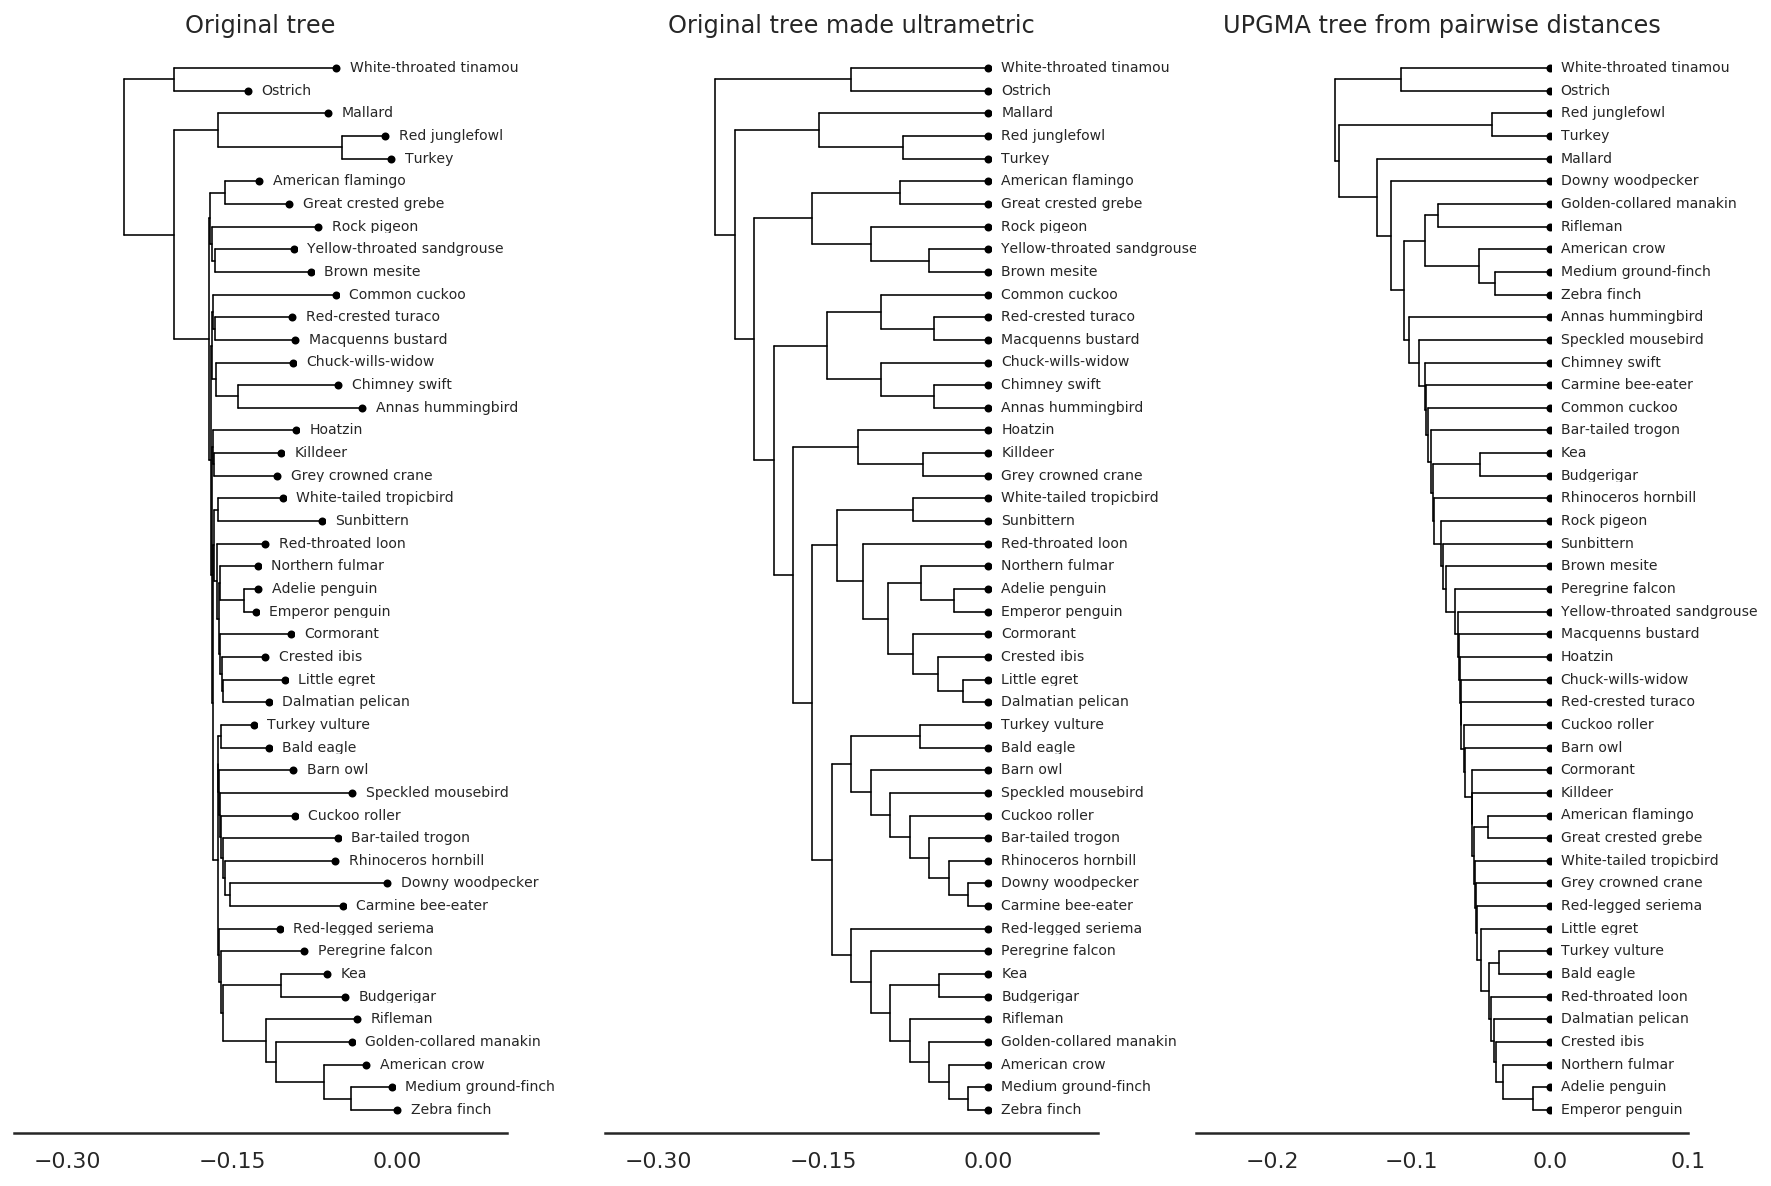

In [35]:
make_comb_tree(tree)
make_comb_tree(ultrametric_tree)
make_comb_tree(upgma_tree)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
leaf_info = plot_tree(tree, ax1, margins=(1, 0.1, 1, 0.1), fontsize=7)
ax1.set_title('Original tree')
leaf_info = plot_tree(ultrametric_tree, ax2, margins=(1, 0.1, 1, 0.1), fontsize=7)
ax2.set_title('Original tree made ultrametric')
leaf_info = plot_tree(upgma_tree, ax3, margins=(1, 0.1, 1, 0.1), fontsize=7)
ax3.set_title('UPGMA tree from pairwise distances') ;

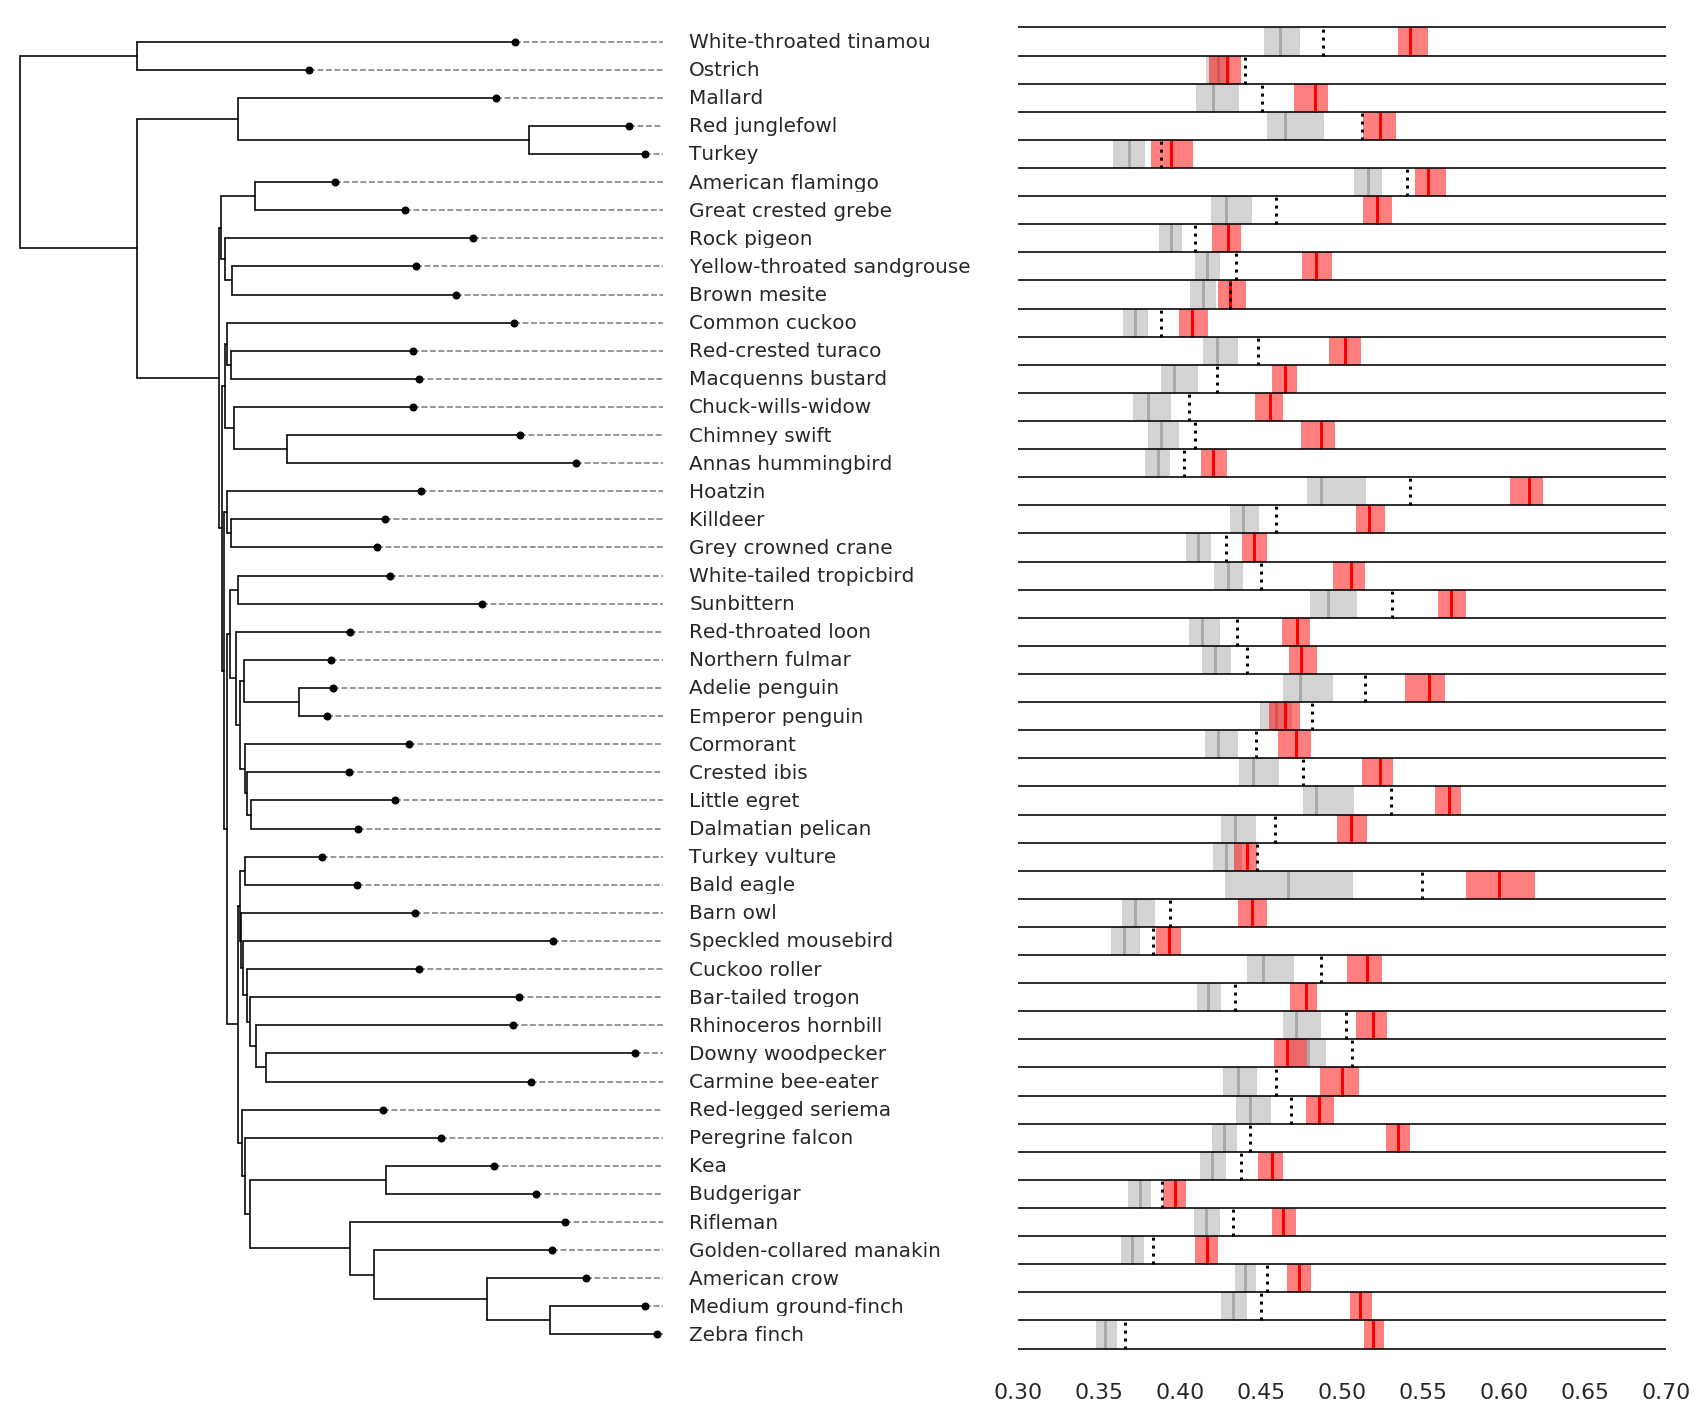

In [36]:
from itertools import groupby
from operator import itemgetter

def jonas_plot(tree, data, figsize=(12, 10)):

    with sns.axes_style('whitegrid'):

        fig = plt.figure(figsize=figsize) 
        gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
        ax0 = plt.subplot(gs[0])
        ax1 = plt.subplot(gs[1])

        leaf_info = plot_tree(tree, ax0, margins=(1, 0.002, 1, 0.002), 
                              fontsize=10, align_labels=True)
        
        with sns.axes_style('white'):
            
            names, x_coords, y_coords = zip(*leaf_info)
            
            for n, x, y in zip(names, x_coords, y_coords):
                
                n = n.split('_', 1)[0]

                tup = next(data.loc[data.species == n].itertuples())

                ax1.add_patch(Rectangle((tup.fmin, y-0.5),tup.fmax-tup.fmin,1,linewidth=0, edgecolor=None, facecolor='lightgrey', zorder=0))
                ax1.add_line(Line2D((tup.fmid, tup.fmid), (y-0.5, y+0.5), color='darkgrey', solid_capstyle='butt', zorder=1))

                ax1.add_patch(Rectangle((tup.hmin, y-0.5),tup.hmax-tup.hmin,1,linewidth=0, edgecolor=None, facecolor='red', alpha=0.5, zorder=2))                
                ax1.add_line(Line2D((tup.hmid, tup.hmid), (y-0.5, y+0.5), color='red', solid_capstyle='butt', zorder=3))     
                
                ax1.add_line(Line2D((tup.fmid*tup.skew, tup.fmid*tup.skew), (y-0.5, y+0.5), color='black', solid_capstyle='butt', linestyle='dotted', zorder=4))

            for y in range(len(leaf_info)+1):
                ax1.axhline(y=y-0.5, color='black', linewidth=0.8, zorder=5)                
                
                
            ax1.get_yaxis().set_visible(False)

#             def format_func(value, tick_number):
#                 if value % 100000:
#                     return '' # only ticks for even 100
#                 return "{:.1f}".format((value + start)/1000000)

#             ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

            ax0.grid(False)
            ax0.spines['top'].set_visible(False) 
            ax0.spines['left'].set_visible(False) 
            ax0.spines['right'].set_visible(False) 
            ax0.spines['bottom'].set_visible(False)
            ax0.get_xaxis().set_visible(False)


            ax1.grid(False)
            ax1.spines['top'].set_visible(False) 
            ax1.spines['left'].set_visible(False) 
            ax1.spines['right'].set_visible(False) 
            ax1.spines['bottom'].set_visible(False) 

            ax1.set_xlim(0.3, 0.7)
            ax1.set_ylim(ax0.get_ylim())

            plt.tight_layout()    

        return fig

    
data = pd.read_csv('/home/kmt/Birds/faststorage/data/fig1_data.txt', sep=' ')

fig = jonas_plot(tree, data)
plt.savefig(figures_path / 'fig1.pdf')

**GC star in hotspots and flanks:** Grey:flanks, Red: hotspots, Dashed line: GC star hotspot required for significant difference at hotspot.

Bootstrapping is across hotspots.

"Skewed the number of different substitutions in the hotspots in each of the bootstrapped records, while maintaining the total number of substitutions, until their bias equaled the flanks. Then we stepwise skewed the substitution pattern back until the confidence intervals (again, paired t-test?) of the GC* values no longer overlapped and recorded this as the detection limit."

Get external branch lengths:

In [37]:
records = list()
for node in tree.traverse():
    if node.is_leaf():
        records.append((node.name.split('_')[0], node.up.name, node.get_distance(node.up)))
orig_branch_lengths = pd.DataFrame.from_records(records, columns=['species', 'ancestor', 'branch_length'])

records = list()
for node in ultrametric_tree.traverse():
    if node.is_leaf():
        records.append((node.name.split('_')[0], node.get_distance(node.up)))
ultrametric_branch_lengths = pd.DataFrame.from_records(records, columns=['species', 'ultra_branch_length'])

branch_lengths = (orig_branch_lengths
 .merge(ultrametric_branch_lengths, on='species')
)
branch_lengths.head()

,species,ancestor,branch_length,ultra_branch_length
0,TINGU,Anc02,0.147138,0.124090
1,STRCA,Anc02,0.066905,0.124090
2,ANAPL,Anc04,0.100287,0.153635
3,GALGA,Anc07,0.039056,0.076818
4,MELGA,Anc07,0.044937,0.076818


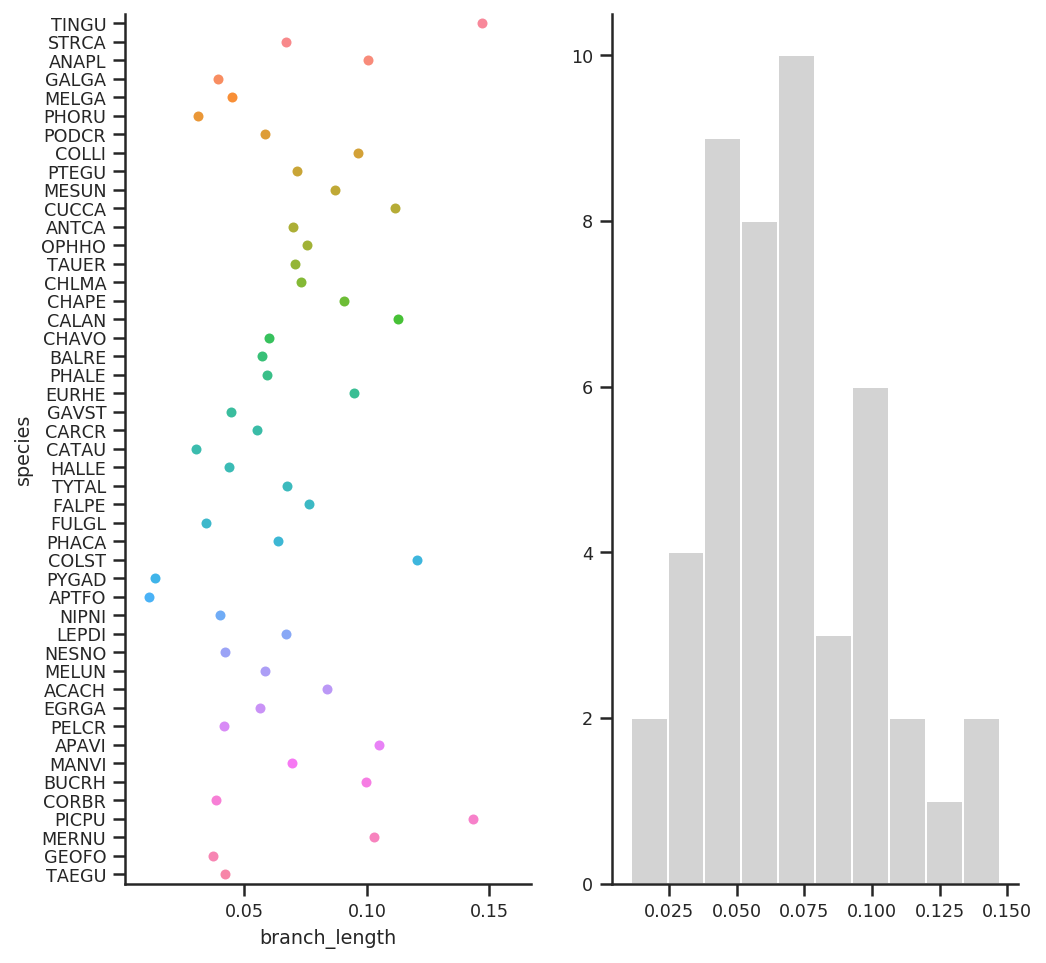

In [38]:
plot_df = branch_lengths.reset_index()#.loc[lambda df: ~df.species.str.startswith('Anc')]

with sns.axes_style("ticks"):
    with sns.plotting_context('notebook', font_scale=0.8):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))
        ax = sns.stripplot(y="species", x="branch_length", 
                           data=plot_df,
                           jitter=0, ax=ax1)
        ax = ax2.hist(plot_df.branch_length, color='lightgrey')
        sns.despine()

## Load data

Hotspot data:

In [39]:
hotspots = pd.read_csv('/project/Birds/faststorage/data/bed/hotspots.bed', names=['chrom', 'start', 'end'], sep='\t')
hotspots['pos'] = (hotspots.start + (hotspots.end - hotspots.start) / 2).round().astype(int)
hotspots['chrom'] = hotspots.chrom.str.replace('chr', '')
hotspots.rename(columns={'stop': 'end'}, inplace=True)
hotspots.head()

,chrom,start,end,pos
0,1,6892116,6896116,6894116
1,1,8803005,8807005,8805005
2,1,9684030,9690030,9687030
3,1,10395061,10399061,10397061
4,1,10500751,10506751,10503751


CGI data:

In [40]:
cgi = pd.read_csv('/project/Birds/faststorage/data/bed/CGI-taeGut1.txt', sep='\t')
cgi['pos'] = (cgi.start + (cgi.end - cgi.start) / 2).round().astype(int)
cgi['chrom'] = cgi['chr'].str.replace('chr', '')
cgi.head()

,chr,start,end,length,CpGcount,GCcount,pctGC,obsExp,pos,chrom
0,chr1,21810,21940,131,9,83,0.633588,0.685465,21875,1
1,chr1,31020,31136,117,15,82,0.700855,1.054054,31078,1
2,chr1,32772,33056,285,23,202,0.708772,0.642584,32914,1
3,chr1,47794,48027,234,12,130,0.555556,0.668571,47910,1
4,chr1,108367,108549,183,9,93,0.508197,0.772514,108458,1


## Functions for remapping from centers of hotspots

In [41]:
import genominterv

importlib.reload(genominterv)

chromosomes = ['1', '1A', '2', '3', '4', '4A', '5', '6', '7', 
               '8', '9', '10', '11', '12', '13', '14', '15']

def get_remapped(query, annot):
    "Remaps all annot that does not overlap query"
    
    remapped = (genominterv.remap_interval_data(query, annot)
                      # exclude windows between ends of chromosomes and a hotspot:
                      .loc[lambda df: ~df.prox_start.isnull() & ~df.prox_end.isnull()]
                     )
    return remapped

def get_overlapping(query, annot):
    "Gets all query that spans an annot"
    
    query_grouped = query.groupby('chrom')
    annot_grouped = annot.groupby('chrom')

    df_list = list()
    for chrom in chromosomes:
        query_group = query_grouped.get_group(chrom)
        annot_group = annot_grouped.get_group(chrom)

        query_starts = query_group.start.tolist()
        query_ends = query_group.end.tolist()

        idx_list = list()    
        for pos in annot_group.pos:
            idx = bisect.bisect_right(query_starts, pos) - 1
            if pos < query_ends[idx]:
                idx_list.append(idx)
#             else:
#                 print(chrom, pos, query_starts[idx], query_ends[idx])
            idx_list = sorted(set(idx_list))
        df_list.append(query_group.iloc[idx_list])

    query_overlap = pd.concat(df_list).reset_index(drop=True)

    # Add the extra columns that are in `skew_data_dist` so concatention is possible and set `start` and `end` to 0:
    query_overlap['prox_start'] = query_overlap.start
    query_overlap['prox_end'] = query_overlap.end

    query_overlap['start_orig'] = query_overlap.start
    query_overlap['end_orig'] = query_overlap.end
    query_overlap['start'] = 0
    query_overlap['end'] = 0

    return query_overlap


def remap_data(query, annot):
    "Remap hotspot centers relative to other annotation intervals"
    
    annot_centers = annot.assign(start=annot.pos, end=annot.pos)
    
    query_dist = get_remapped(query, annot_centers)

    # must be single base annotation annotation
    # for this to work (hotspot centers)
    assert not (annot_centers.end - annot_centers.start).sum()    
    query_overlap = get_overlapping(query, annot_centers)

    merged = pd.concat([query_overlap, query_dist], sort=True)
    
    merged['pos'] = (merged.start + (merged.end - merged.start) / 2).astype(float).round().astype(int)
    merged['bin'] = merged.pos // 1000 * 1000

    return merged

In [42]:
def optimize_data_frame(df, inplace=False, down_int='integer'):
    # down_int can be 'unsigned'
    
    if inplace:
        converted_df = df
    else:
        converted_df = pd.DataFrame()

    floats_optim = (df
                    .select_dtypes(include=['float'])
                    .apply(pd.to_numeric,downcast='float')
                   )
    converted_df[floats_optim.columns] = floats_optim

    ints_optim = (df
                    .select_dtypes(include=['int'])
                    .apply(pd.to_numeric,downcast=down_int)
                   )
    converted_df[ints_optim.columns] = ints_optim

    for col in df.select_dtypes(include=['object']).columns:
        num_unique_values = len(df[col].unique())
        num_total_values = len(df[col])
        if num_unique_values / num_total_values < 0.5:
            converted_df[col] = df[col].astype('category')
        else:
            converted_df[col] = df[col]

    unchanged_cols = df.columns[~df.columns.isin(converted_df.columns)]
    converted_df[unchanged_cols] = df[unchanged_cols]

    # keep columns order
    converted_df = converted_df[df.columns]      
            
    return converted_df

## Read and remap data relative to hotspots

In [43]:
composition_data_path = data_path / 'composition_cpg'

composition_data_path_remapped = data_path / 'composition_cpg_remapped'
if not composition_data_path_remapped.exists():
    os.makedirs(composition_data_path_remapped)

In [44]:
species_dirs = [x for x in composition_data_path.iterdir() if x.is_dir()]

for species_dir in species_dirs:
    
    
    outfile_hotspots = composition_data_path_remapped / species_dir.with_suffix('.hotspot_relative.txt').name
    outfile_cgi = composition_data_path_remapped / species_dir.with_suffix('.cgi_relative.txt').name
    
#     outfile_hotspots = species_dir.with_suffix('.hotspot_relative.txt')
#     outfile_cgi = species_dir.with_suffix('.cgi_relative.txt')

#     if outfile_hotspots.exists() and outfile_cgi.exists():
#         continue
    
    print(species_dir.name, sep=' ')
    
#     if species_dir.name == "PICPU":
#         print("Skipping PICPU")
#         continue
        
    # read data for species
    df_list = list()
    for chrom_file in species_dir.iterdir():
        
        if not chrom_file.name.endswith('.composition.1000.txt'):
            continue
        
        df = pd.read_csv(chrom_file, sep='\t')
        df['species'] = species_dir.name
        df['end'] = df.start + 1000
        chrom = chrom_file.name.split('.')[0].replace('chr', '')
        df['chrom'] = chrom
        df_list.append(df)
    data = pd.concat(df_list) 
    
    # remap to hotspots and and write file
    remapped = remap_data(data, hotspots)
    remapped.to_csv(outfile_hotspots, sep='\t', index=False)
    
    # remap to cgi and and write file
    remapped = remap_data(data, cgi)
    remapped.to_csv(outfile_cgi, sep='\t', index=False)

APAVI
PELCR
CARCR
CATAU
PHACA
FALPE
TYTAL
GALGA
HALAL
MANVI
COLST
NIPNI
TAEGU


OSError: Initializing from file failed

In [15]:
df_list = list()
for path in composition_data_path.iterdir():
    if path.name.endswith('.hotspot_relative.txt'):
        df = pd.read_csv(str(path), sep='\t', low_memory=False)
        df_list.append(df)
hotspot_table = pd.concat(df_list, sort=True).merge(branch_lengths, on=['species', 'ancestor'], how='left')

optimize_data_frame(hotspot_table).to_hdf(results_path / 'hotspot_data.h5', 'df', mode='w', format='table')

In [16]:
del hotspot_table
gc.collect()

251

In [17]:
df_list = list()
for path in composition_data_path.iterdir():
    if path.name.endswith('.cgi_relative.txt'):
        df = pd.read_csv(str(path), sep='\t', low_memory=False)
        df_list.append(df)
cgi_table = pd.concat(df_list, sort=True).merge(branch_lengths, on=['species', 'ancestor'], how='left')

optimize_data_frame(cgi_table).to_hdf(results_path / 'cgi_data.h5', 'df', mode='w', format='table')